ADMM を用いた TV 正則化 MRI 再構成

TotalVariationRecon: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s, obj=1.32E+01]


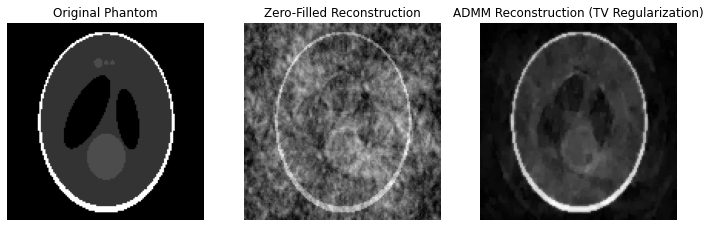

In [6]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction (Adjoint NUFFT)**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. デバイス設定**
try:
    device = sp.Device(0)  # GPU がある場合
except:
    device = sp.Device(-1)  # CPU で実行

device.use()

# **7. ADMM の設定**
lamda = 0.01  # TV 正則化の強さ
rho = 1  # ADMM のペナルティ係数
max_iter = 50  # 反復回数
max_cg_iter = 5  # ADMM の各ステップでの CG 反復数

# **TV 正則化オペレータの最大固有値を計算**
G = sp.linop.FiniteDifference(img_shape)
max_eig_G = sp.app.MaxEig(G.H * G).run()

# **Preconditioner を適用**
p = mri.kspace_precond(mps, coord=coords, device=device)
sigma2 = np.ones([np.prod(img_shape) * len(img_shape)], dtype=ksp.dtype) / max_eig_G
sigma = np.concatenate([p.ravel(), sigma2.ravel()]) / rho  # ADMM 用に調整
# sigma = 0  #preconditioner を使わない場合

# **8. ADMM による SENSE + TV 再構成**
tv_admm_app = mri.app.TotalVariationRecon(
    ksp, mps, lamda=lamda, coord=coords, sigma=sigma, max_iter=max_iter // max_cg_iter,
    solver='ADMM', rho=rho, max_cg_iter=max_cg_iter, device=device,
    save_objective_values=True  # 追加
)

# **9. ADMM の実行**
reconstructed_img_admm = tv_admm_app.run()  # `run()` をそのまま使う

# **10. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img_admm), cmap="gray")
axs[2].set_title("ADMM Reconstruction (TV Regularization)")
axs[2].axis("off")

plt.show()
